In [1]:
import numpy as np
import pandas as pd
import librosa
import os
import glob
import re
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import time
import collections
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import pickle
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from pathlib import Path
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')

## Configuration data

In [10]:
data_dir="/home/malvarez/TFG2/Instrumentos/DataInput/Preprocessed/"
models_dir='/home/malvarez/TFG2/Instrumentos/Models/CNN/'
imagetype='X_MFCC'
model_folder='/Ejemplo1/' #Change, you need a different model for each training

#Convolutional layers
layers=2

batch_size = 100 #1000
#training epochs
epochs = 1000
#assume we dont need data augmentation
#data_augmentation = False

## User defined functions

In [11]:
def LoadPreprocessImage(data_dir,imagetype,settype):
    """
    Define function that takes a data file with images and pre-processit to make it have the correct format 
    for Keras (i.e. samples * wx * wy * 1)
    """
    
    #We load the file 
    with open(data_dir+imagetype+"_"+settype+".pickle", 'rb') as f:
        X = pickle.load(f)
    
    #We add the single forth dimension
    sh=X.shape
    sh=list(sh)
    sh.append(1)
    
    X=X.reshape(sh)
    
    print(X.shape)
    
    return X

In [12]:
def LoadPreprocessLabels(data_dir,settype,num_classes):
    """
    Define function that takes a Label file and preprocess it to make it have the correct format 
    for Keras (it delets the non valid set, and make it 1hot)
    """
    
    with open(data_dir+"Y_"+settype+".pickle", 'rb') as f:
        y = pickle.load(f)
    
    ind=y == 10
    y[ind]=9
    
    print(len(y))
    print(np.unique(y))
    
    if num_classes<0:
        num_classes=np.unique(y).shape[0]
    
    y1hot=utils.to_categorical(y,num_classes=num_classes)
    
    return [y,y1hot,num_classes]

In [13]:
def PrepareSingleCNN(shape,layers,num_classes):
    
    model = Sequential()
    
    u=32
    
    #We add as many intermediate layers as indicated in layers
    for i in range(layers):
        model.add(Conv2D(u, (3, 3), padding='same',
                 input_shape=X_train.shape[1:], data_format='channels_last'))
        model.add(Activation('relu'))
        model.add(Conv2D(u, (3, 3), padding='same', data_format='channels_last'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        u=u*2
        

    model.add(Flatten())
    model.add(Dense(u))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    
    model.summary()
    
    
    opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


    # Let's train the model
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy','acc'])
    
    return model

In [14]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
  
    return ax

### Load Data

In [15]:
#Load Images
X_train=LoadPreprocessImage(data_dir,imagetype,'train')
X_test=LoadPreprocessImage(data_dir,imagetype,'test')
X_valid=LoadPreprocessImage(data_dir,imagetype,'valid')

(500, 13, 173, 1)
(50, 13, 173, 1)
(50, 13, 173, 1)


In [16]:
#load targets
Y_train,Y1hot_train,num_classes=LoadPreprocessLabels(data_dir,'train',-1)
Y_test,Y1hot_test,cc=LoadPreprocessLabels(data_dir,'test',num_classes)
Y_valid,Y1hot_valid,cc=LoadPreprocessLabels(data_dir,'valid',num_classes)

500
[0 1 2 3 4 5 6 7 8 9]
50
[0 1 2 3 4 5 6 7 8 9]
50
[0 1 2 3 4 5 6 7 8 9]


## Prepare model

In [17]:
model=PrepareSingleCNN(X_train.shape[1:],layers,num_classes)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 13, 173, 32)       320       
_________________________________________________________________
activation_6 (Activation)    (None, 13, 173, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 173, 32)       9248      
_________________________________________________________________
activation_7 (Activation)    (None, 13, 173, 32)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 86, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 86, 32)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 86, 64)        

## Train model

In [18]:
history = model.fit(X_train, Y1hot_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, Y1hot_valid),
          shuffle=True)

Epoch 1/5
25/25 [==============================] - 1s 59ms/step - loss: 6.4714 - accuracy: 0.1280 - acc: 0.1280 - val_loss: 2.2315 - val_accuracy: 0.0800 - val_acc: 0.0800
Epoch 2/5
25/25 [==============================] - 1s 53ms/step - loss: 2.8118 - accuracy: 0.1300 - acc: 0.1300 - val_loss: 2.2124 - val_accuracy: 0.2000 - val_acc: 0.2000
Epoch 3/5
25/25 [==============================] - 1s 53ms/step - loss: 2.5318 - accuracy: 0.0880 - acc: 0.0880 - val_loss: 2.2260 - val_accuracy: 0.2200 - val_acc: 0.2200
Epoch 4/5
25/25 [==============================] - 1s 53ms/step - loss: 2.3802 - accuracy: 0.1240 - acc: 0.1240 - val_loss: 2.2210 - val_accuracy: 0.1200 - val_acc: 0.1200
Epoch 5/5
25/25 [==============================] - 1s 53ms/step - loss: 2.3841 - accuracy: 0.1340 - acc: 0.1340 - val_loss: 2.2151 - val_accuracy: 0.1600 - val_acc: 0.1600


In [19]:
#Prepare model folder, in case it does not exist
models_dir=models_dir+imagetype+model_folder
if not os.path.isdir(models_dir):
    os.makedirs(models_dir)

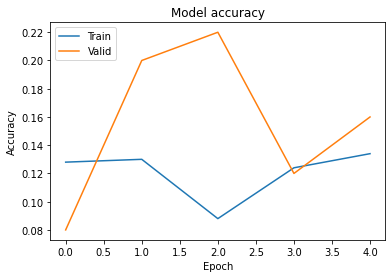

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig(models_dir+'accuracy.png')
plt.show()
plt.clf()

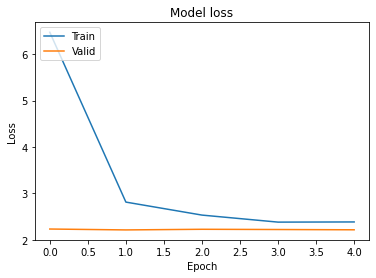

<Figure size 432x288 with 0 Axes>

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig(models_dir+'loss.png')
plt.show()
plt.clf()

In [22]:
# Save model and weights
model_path = os.path.join(models_dir,"model")
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/alver/Desktop/TFG/TFG2/Instrumentos/Models/CNN/X_MFCC/Ejemplo1/model\assets
Saved trained model at C:/Users/alver/Desktop/TFG/TFG2/Instrumentos/Models/CNN/X_MFCC/Ejemplo1/model 


In [23]:
# Score trained model.
scores = model.evaluate(X_test, Y1hot_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
file = open(models_dir + "Precisiones.txt","w")
file.write('Test loss: {0:.3}\n'.format(scores[0]))
file.write('Test accuracy: {0:.2%}'.format(scores[1]))
file.close()

2/2 [==============================] - 0s 4ms/step - loss: 2.2025 - accuracy: 0.2800 - acc: 0.2800
Test loss: 2.202526330947876
Test accuracy: 0.2800000011920929


In [24]:
Y_pred = model.predict_classes(X_test)
print(Y_pred)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[6 5 5 5 5 2 1 5 7 2 1 2 1 5 5 1 2 5 5 2 5 5 1 6 7 7 6 1 5 1 1 0 1 1 5 5 1
 7 1 1 5 0 1 5 5 5 5 5 1 5]


In [25]:
class_names=np.array(['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'vocal'])
print(Y_test)
print(class_names)

[6 0 1 4 4 1 7 4 2 2 8 9 8 3 4 6 2 5 5 2 4 5 9 6 3 9 6 7 0 8 1 3 7 8 2 8 1
 9 1 9 5 6 7 5 7 0 3 3 0 0]
['bass' 'brass' 'flute' 'guitar' 'keyboard' 'mallet' 'organ' 'reed'
 'string' 'vocal']


Normalized confusion matrix
[[0.  0.2 0.  0.  0.  0.8 0.  0.  0.  0. ]
 [0.  0.6 0.2 0.  0.  0.2 0.  0.  0.  0. ]
 [0.  0.  0.6 0.  0.  0.2 0.  0.2 0.  0. ]
 [0.2 0.  0.  0.  0.  0.6 0.  0.2 0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.2 0.2 0.  0.  0.  0.  0.6 0.  0.  0. ]
 [0.  0.8 0.  0.  0.  0.2 0.  0.  0.  0. ]
 [0.  0.8 0.  0.  0.  0.2 0.  0.  0.  0. ]
 [0.  0.4 0.2 0.  0.  0.  0.  0.4 0.  0. ]]


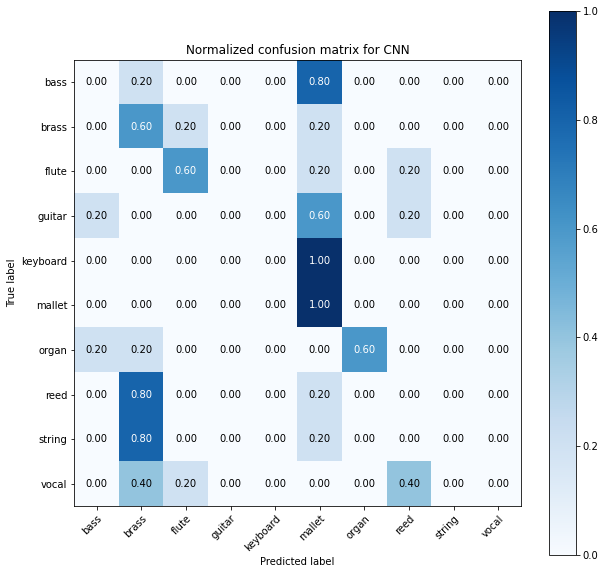

In [26]:
plot_confusion_matrix(Y_test, Y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for CNN')

plt.savefig(models_dir+'ConfusionMatrix_normalized.png')